In [8]:
import openai
from openai import OpenAI
import os
import base64
import requests
from key import OPENAI_API_KEY
import math
import numpy as np
from datetime import timedelta

In [9]:
# Initialize client
api_key=OPENAI_API_KEY
client = OpenAI(api_key=api_key)

In [10]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def list_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:  
            file_list.append(os.path.join(root, file))
    return file_list

# Get url name
from video import extract_youtube_id
url = extract_youtube_id("https://www.youtube.com/watch?v=hFkJJkFIA2I")

# Get all the image paths
directory = './frames/' + url  # When you run video.py, all the frames located inside frames folder
image_paths = list_files(directory)

In [11]:
directory

'./frames/hFkJJkFIA2I'

In [12]:
# Get System Prompt
f = open("prompt.txt", "r")
prompt_text = f.read()

# Get User Input
user_input = "great moments"

In [13]:
# results = []

# # Iterate through each image path
# for image_path in image_paths:
#     # Getting the base64 string
#     base64_image = encode_image(image_path)

#     headers = {
#         "Content-Type": "application/json",
#         "Authorization": f"Bearer {api_key}"
#     }

#     payload = {
#         "model": "gpt-4o",
#         "messages": [
#             {"role": "system", "content": prompt_text},
#             {"role": "user", "content": [{"type": "text", "text": user_input}, {"type": "image_url","image_url": {"url": f"data:image/jpg;base64,{base64_image}", "detail": "low"}}]}
#             # user_input text can be removed
#         ],
#         "max_tokens": 4096
#     }

#     # Make the API request
#     response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

#     # Append the result to the list
#     results.append(response.json())

In [14]:
# import concurrent.futures
# import base64
# import requests

# def make_api_request(image_path, api_key, prompt_text, user_input):
#     base64_image = encode_image(image_path)

#     headers = {
#         "Content-Type": "application/json",
#         "Authorization": f"Bearer {api_key}"
#     }

#     payload = {
#         "model": "gpt-4o",
#         "messages": [
#             {"role": "system", "content": prompt_text},
#             {"role": "user", "content": [
#                 {"type": "text", "text": user_input},
#                 {"type": "image_url", "image_url": {"url": f"data:image/jpg;base64,{base64_image}", "detail": "low"}}
#             ]}
#         ],
#         "max_tokens": 4096
#     }

#     response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
#     return response.json()

# def process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=10):
#     results = []
#     with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
#         future_to_image = {executor.submit(make_api_request, image_path, api_key, prompt_text, user_input): image_path for image_path in image_paths}
#         for future in concurrent.futures.as_completed(future_to_image):
#             image_path = future_to_image[future]
#             try:
#                 result = future.result()
#                 results.append(result)
#             except Exception as exc:
#                 print(f'{image_path} generated an exception: {exc}')

#     return results

# results = process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=10)
# print(results)

In [15]:
import concurrent.futures
import base64
import requests

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def make_api_request(image_paths, api_key, prompt_text, user_input):
    # Encode all images in the list
    base64_images = [encode_image(image_path) for image_path in image_paths]

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    # Prepare the images for the payload
    images_payload = [{"type": "image_url", "image_url": {"url": f"data:image/jpg;base64,{img}", "detail": "low"}} for img in base64_images]

    payload = {
        "model": "gpt-4o",
        "messages": [
            {"role": "system", "content": prompt_text},
            {"role": "user", "content": [
                {"type": "text", "text": user_input},
                *images_payload
            ]}
        ],
        "max_tokens": 1600
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

def process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=10, frames_per_request=3):
    results = []

    # Split image_paths into chunks of frames_per_request
    image_chunks = [image_paths[i:i + frames_per_request] for i in range(0, len(image_paths), frames_per_request)]

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_image_chunk = {executor.submit(make_api_request, chunk, api_key, prompt_text, user_input): chunk for chunk in image_chunks}
        for future in concurrent.futures.as_completed(future_to_image_chunk):
            image_chunk = future_to_image_chunk[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as exc:
                print(f'{image_chunk} generated an exception: {exc}')

    return results

results = process_images_in_parallel(image_paths, api_key, prompt_text, user_input, num_threads=30, frames_per_request=3)
print(results)

['./frames/hFkJJkFIA2I\\027_0.jpg', './frames/hFkJJkFIA2I\\027_1.jpg', './frames/hFkJJkFIA2I\\027_2.jpg'] generated an exception: Expecting value: line 1 column 1 (char 0)
[{'id': 'chatcmpl-9hgKxivNbG4SjKVPLurGa6cUVGQ6t', 'object': 'chat.completion', 'created': 1720197875, 'model': 'gpt-4o-2024-05-13', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '### Explanation\n\n- **Main Subjects:** A person standing on an indoor balcony.\n- **Actions:** The person is looking down from the balcony, observing something or someone below.\n- **Context:** The images capture a calm moment within a home, showing a person pausing on an indoor balcony, likely taking in a view or interacting with someone in another part of the house. The setting seems serene, with natural light adding warmth to the scene.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 1130, 'completion_tokens': 89, 'total_tokens': 1219}, 'system_fingerprint': 'fp_4008e3b719'}, {'id': 'chat

In [16]:
# Result Sample
results[0]

{'id': 'chatcmpl-9hgKxivNbG4SjKVPLurGa6cUVGQ6t',
 'object': 'chat.completion',
 'created': 1720197875,
 'model': 'gpt-4o-2024-05-13',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': '### Explanation\n\n- **Main Subjects:** A person standing on an indoor balcony.\n- **Actions:** The person is looking down from the balcony, observing something or someone below.\n- **Context:** The images capture a calm moment within a home, showing a person pausing on an indoor balcony, likely taking in a view or interacting with someone in another part of the house. The setting seems serene, with natural light adding warmth to the scene.'},
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 1130,
  'completion_tokens': 89,
  'total_tokens': 1219},
 'system_fingerprint': 'fp_4008e3b719'}

In [17]:
# Iterate through all the results
missing_count = 0
missing_list = list()
captions_dict = {}

def seconds_to_hhmmss(seconds):
    return str(timedelta(seconds=seconds))

captions_dict = {}


for i in range(len(results)):
    try:
        caption = results[i]['choices'][0]['message']['content']
        start_time = i * 5   # Time interval (5 seconds)
        captions_dict[seconds_to_hhmmss(start_time)] = caption
        print(i, ": ", caption)
        
    except KeyError:
        print(i, ": missing")
        captions_dict[seconds_to_hhmmss(i*5)] = "Missing"
        missing_count += 1
        missing_list.append(i)

print("\nMissing count: ", missing_count, "\nMissing List: ", missing_list)

0 :  ### Explanation

- **Main Subjects:** A person standing on an indoor balcony.
- **Actions:** The person is looking down from the balcony, observing something or someone below.
- **Context:** The images capture a calm moment within a home, showing a person pausing on an indoor balcony, likely taking in a view or interacting with someone in another part of the house. The setting seems serene, with natural light adding warmth to the scene.
1 :  #### Daily Vlog
- Main Subjects: A young man
- Actions: The young man starts with a slight smile, then transitions into a broader smile, and ends with a joyful laugh.
- Context: The images depict a cheerful moment outside a house. The young man appears to be recording himself, capturing a happy and relaxed segment of his daily vlog in a comfortable and familiar environment.
2 :  ### Daily Vlog

- **Main Subjects:** A man in a black shirt (first image) and a man in a white shirt (third image).
- **Actions:** The man in the black shirt is likely

In [18]:
import json 
with open('./results/captions.json', 'w') as file:  
    json.dump(captions_dict, file)

In [19]:
embedding_model = 'text-embedding-3-small'
texts = results

def get_embedding(text, model=embedding_model):
    return client.embeddings.create(input=[text], model=model).data[0].embedding

def process_embeddings_in_parallel(results, model=embedding_model, num_threads=len(results)):
    def embed_result(result):
        return get_embedding(result['choices'][0]['message']['content'], model=model)
    
    embedded_frame = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        future_to_index = {executor.submit(embed_result, result): i for i, result in enumerate(results)}
        for future in concurrent.futures.as_completed(future_to_index):
            i = future_to_index[future]
            try:
                embedding = future.result()
                embedded_frame[i] = np.array(embedding).reshape(1, -1)
            except Exception as exc:
                print(f'Embedding for result {i} generated an exception: {exc}')

    return embedded_frame

# Usage
embedded_frame = process_embeddings_in_parallel(texts, model=embedding_model, num_threads=len(results))

# Embed the query
embedded_query = get_embedding(user_input, model=embedding_model)
embedded_query = np.array(embedded_query).reshape(1, -1)

print(embedded_frame)
print(embedded_query)

{20: array([[ 0.05890478, -0.00011505, -0.06298065, ...,  0.01372118,
        -0.02199856,  0.03807873]]), 27: array([[ 0.02515372,  0.04483297, -0.05687679, ..., -0.0139959 ,
        -0.04304656,  0.02694012]]), 21: array([[ 0.01473736, -0.01087757, -0.04222132, ..., -0.01594041,
        -0.02891616,  0.03723726]]), 16: array([[ 0.0532334 ,  0.020436  , -0.06147434, ...,  0.00751794,
        -0.02840821,  0.02605366]]), 18: array([[ 0.02224324,  0.03561474, -0.03937308, ...,  0.00383184,
        -0.05266789,  0.01420243]]), 10: array([[ 0.01597142,  0.02475396, -0.01286555, ...,  0.01116139,
        -0.02742944, -0.0148547 ]]), 17: array([[ 0.03729472,  0.02324713, -0.05812436, ..., -0.01005546,
        -0.03747767,  0.02801678]]), 2: array([[ 0.03342012,  0.02310722, -0.06087339, ..., -0.00887856,
        -0.03514133,  0.0286868 ]]), 6: array([[ 0.05078267,  0.01650304, -0.04024938, ..., -0.00478575,
        -0.02966302,  0.01560095]]), 29: array([[ 0.06416755, -0.00864836, -0.034992

In [20]:
embedded_frame

{20: array([[ 0.05890478, -0.00011505, -0.06298065, ...,  0.01372118,
         -0.02199856,  0.03807873]]),
 27: array([[ 0.02515372,  0.04483297, -0.05687679, ..., -0.0139959 ,
         -0.04304656,  0.02694012]]),
 21: array([[ 0.01473736, -0.01087757, -0.04222132, ..., -0.01594041,
         -0.02891616,  0.03723726]]),
 16: array([[ 0.0532334 ,  0.020436  , -0.06147434, ...,  0.00751794,
         -0.02840821,  0.02605366]]),
 18: array([[ 0.02224324,  0.03561474, -0.03937308, ...,  0.00383184,
         -0.05266789,  0.01420243]]),
 10: array([[ 0.01597142,  0.02475396, -0.01286555, ...,  0.01116139,
         -0.02742944, -0.0148547 ]]),
 17: array([[ 0.03729472,  0.02324713, -0.05812436, ..., -0.01005546,
         -0.03747767,  0.02801678]]),
 2: array([[ 0.03342012,  0.02310722, -0.06087339, ..., -0.00887856,
         -0.03514133,  0.0286868 ]]),
 6: array([[ 0.05078267,  0.01650304, -0.04024938, ..., -0.00478575,
         -0.02966302,  0.01560095]]),
 29: array([[ 0.06416755, -0.0

In [21]:
# embedding_model = 'text-embedding-3-small'
# def get_embedding(text, model=embedding_model):
#    return client.embeddings.create(input = [text], model=model).data[0].embedding

# embedded_frame = {}
# for i in range(len(results)):
#     embedded_frame[i] = get_embedding(results[i]['choices'][0]['message']['content'], model=embedding_model)
#     embedded_frame[i] = np.array(embedded_frame[i]).reshape(1,-1)

# embedded_query = get_embedding(user_input, model=embedding_model)
# embedded_query = np.array(embedded_query).reshape(1,-1)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_result = {}
for i in range(len(image_paths)//3):
    try:
        similarity_result[seconds_to_hhmmss(i*5)] = cosine_similarity(embedded_frame[i], embedded_query).item()
    except KeyError:
        similarity_result[seconds_to_hhmmss(i*5)] = 0
        
ranked_frame_dict = dict(sorted(similarity_result.items(), key=lambda x:x[1], reverse=True))

In [23]:
ranked_frame_list = list(ranked_frame_dict.keys())
ranked_frame_list[:10]

['0:07:15',
 '0:11:05',
 '0:14:25',
 '0:09:30',
 '0:12:30',
 '0:11:45',
 '0:11:50',
 '0:02:30',
 '0:00:15',
 '0:09:55']

In [24]:
ranked_frame_dict

{'0:07:15': 0.4969453985094649,
 '0:11:05': 0.4200831487386651,
 '0:14:25': 0.37051950195601285,
 '0:09:30': 0.3514933833277143,
 '0:12:30': 0.34375059940304203,
 '0:11:45': 0.33909436255016057,
 '0:11:50': 0.33691345338857825,
 '0:02:30': 0.33293211320836685,
 '0:00:15': 0.32343253389482796,
 '0:09:55': 0.3212347853085331,
 '0:12:45': 0.3188223208337909,
 '0:05:35': 0.31508808697555946,
 '0:12:35': 0.3140458195539081,
 '0:14:10': 0.30858290635998975,
 '0:12:20': 0.3081932667088423,
 '0:11:10': 0.29841802523727223,
 '0:06:25': 0.29686649886084115,
 '0:12:25': 0.29415523458216736,
 '0:13:40': 0.2928507884627214,
 '0:07:50': 0.29170102639150286,
 '0:07:55': 0.2902704400816306,
 '0:01:05': 0.29008164530886094,
 '0:00:45': 0.2895209265449595,
 '0:03:55': 0.2856505598660629,
 '0:10:30': 0.28230959209022577,
 '0:04:00': 0.2816217375334493,
 '0:12:15': 0.2810728702539349,
 '0:03:10': 0.2810677506262998,
 '0:14:15': 0.28076808060245445,
 '0:02:10': 0.2807181139154774,
 '0:12:40': 0.28009195887

In [25]:
import pandas as pd
df = pd.DataFrame(list(ranked_frame_dict.items()), columns=['Time', 'Value'])
df.head()

,Time,Value
0,0:07:15,0.496945
1,0:11:05,0.420083
2,0:14:25,0.370520
3,0:09:30,0.351493
4,0:12:30,0.343751


In [26]:
df.describe()

,Value
count,181.000000
mean,0.252762
std,0.043719
min,0.000000
25%,0.231323
50%,0.249607
75%,0.268051
max,0.496945


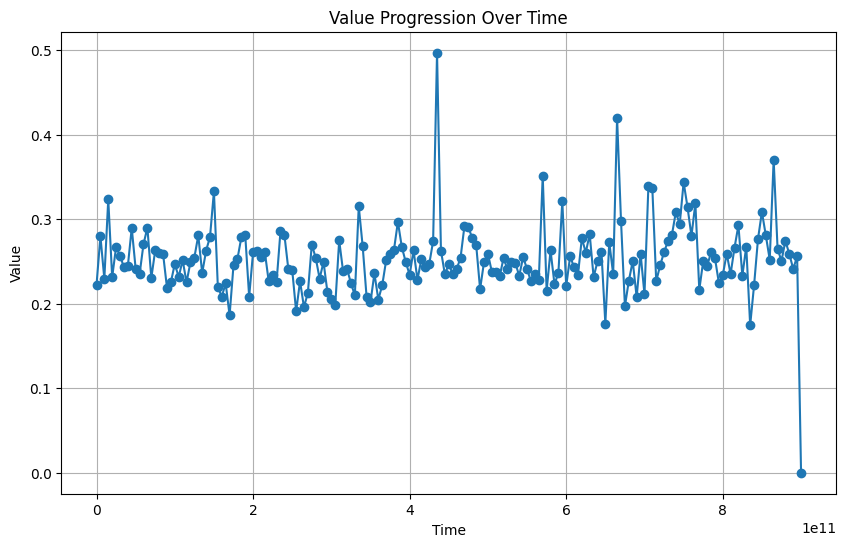

In [27]:
import matplotlib.pyplot as plt
# Convert the 'Time' column to a datetime type for accurate sorting
df['Time'] = pd.to_timedelta(df['Time'])

# Sort the DataFrame by time
df = df.sort_values(by='Time')

# Plot the progression of the values
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Value'], marker='o')
plt.title('Value Progression Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()